# Warli Art Generator

## Import all the necessary libraries and set the device

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


## Get the number of samples in each class. Identify their size and channels

In [3]:
data_dir = '/content/drive/MyDrive/Dataset/Warli Art Dataset'

for category in os.listdir(data_dir):
    if os.path.isdir(os.path.join(data_dir, category)):
        category_dir = os.path.join(data_dir, category)
        image_files = [f for f in os.listdir(category_dir) if f.endswith(('.jpg'))]
        num_images = len(image_files)

        print(f"Category: {category}")
        print(f"Number of images: {num_images}")

        if num_images > 0:
            sample_image_path = os.path.join(category_dir, image_files[0])
            sample_image = Image.open(sample_image_path)
            image_size = sample_image.size
            # num_channels = len(sample_image.mode)
            num_channels = len(sample_image.getbands())

            print(f"Image size: {image_size}")
            print(f"Number of channels: {num_channels}")

        print()

Category: Animals
Number of images: 429
Image size: (1280, 768)
Number of channels: 3

Category: Plants
Number of images: 573
Image size: (1280, 768)
Number of channels: 3

Category: Instruments
Number of images: 565
Image size: (1280, 768)
Number of channels: 3

Category: Farming
Number of images: 399
Image size: (1280, 768)
Number of channels: 3

Category: Sun
Number of images: 641
Image size: (1280, 768)
Number of channels: 3

Category: House
Number of images: 749
Image size: (1280, 768)
Number of channels: 3

Category: Gods Scenes
Number of images: 741
Image size: (1280, 768)
Number of channels: 3

Category: Man
Number of images: 1005
Image size: (1280, 768)
Number of channels: 3

Category: Birds
Number of images: 701
Image size: (1280, 768)
Number of channels: 3

Category: Mountains
Number of images: 353
Image size: (1280, 768)
Number of channels: 3

Category: Utensils
Number of images: 254
Image size: (1280, 768)
Number of channels: 3

Category: Weapon
Number of images: 108
Image

##Writing a data loader


### Example to understand

Transform is used to apply multiple diffrent transformation to an image.
```
transforms.Resize(H, W)
```
Here, we resize the image to **H x W**. For example: transforms.Resize(64, 64) sets H = 64 and W = 64.

Next,
```
transforms.ToTensor()
```
This converts the image into tensors.

Finally,
```
transforms.Normalize(mean, std)
```
Here, the operation would be

(Image_Tensor[i][j] - mean[i][j]) / std[i][j]

For example if we conider a tensor [0.8, 0.2, 0.5] applying transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]) would give you a tensor [0.6, -0.6, 0.0]

In [ ]:
image = Image.open('/content/drive/MyDrive/Dataset/Warli Art Dataset/Animals/Warli001.jpg')

transform1 = transforms.Compose([
    # transforms.Resize(64,64),
    transforms.ToTensor(),
    # transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform2 = transforms.Compose([
    transforms.Resize(2,2),
    transforms.ToTensor(),
    # transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

transform3 = transforms.Compose([
    transforms.Resize(2,2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

tensor_image1 = transform1(image)
tensor_image2 = transform2(image)
tensor_image3 = transform3(image)

print("One: ", tensor_image1)
print()
print("Two: ", tensor_image2)
print()
print("Three: ", tensor_image3)

One:  tensor([[[0.8000, 0.7647, 0.7098,  ..., 0.6627, 0.6667, 0.6706],
         [0.8235, 0.7922, 0.7451,  ..., 0.6588, 0.6627, 0.6627],
         [0.8549, 0.8353, 0.8000,  ..., 0.6588, 0.6549, 0.6549],
         ...,
         [0.8118, 0.8078, 0.8039,  ..., 0.6784, 0.6784, 0.6784],
         [0.8078, 0.8000, 0.7922,  ..., 0.6784, 0.6784, 0.6784],
         [0.8039, 0.7961, 0.7882,  ..., 0.6784, 0.6784, 0.6784]],

        [[0.7961, 0.7608, 0.7098,  ..., 0.6549, 0.6588, 0.6627],
         [0.8196, 0.7882, 0.7412,  ..., 0.6510, 0.6549, 0.6549],
         [0.8510, 0.8314, 0.7961,  ..., 0.6510, 0.6471, 0.6471],
         ...,
         [0.8157, 0.8118, 0.8078,  ..., 0.6588, 0.6588, 0.6588],
         [0.8118, 0.8039, 0.7961,  ..., 0.6588, 0.6588, 0.6588],
         [0.8078, 0.8000, 0.7922,  ..., 0.6588, 0.6588, 0.6588]],

        [[0.7765, 0.7412, 0.6784,  ..., 0.6078, 0.6118, 0.6157],
         [0.8039, 0.7686, 0.7216,  ..., 0.6039, 0.6078, 0.6078],
         [0.8431, 0.8157, 0.7804,  ..., 0.6039, 0.60

###Dataloader
```
ImageFolder(data_pth, transfrom=transform)
```
Image folder is used to load data (image in this case) form **dir** where the **dir** is the category of the image

It encodes the categories as an integer

like category1 = 0, category2 = 1, etc..

It also maintains a mapping of class to integers



In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# Path to data
data_pth = '/content/drive/MyDrive/Dataset/Warli Art Dataset'

# Dataloader

# Dataloader
dataset = ImageFolder(data_pth, transform=transform)
total_samples = len(dataset)
train_samples = int(0.5 * total_samples)  # 60% of the total samples
val_samples = total_samples - train_samples

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_samples, val_samples])

batch_size = 64
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Print Images to verify
1.  Undo the normalization
```
img = img / 2 + 0.5
```

2. Convert the PyTorch tensor to numpy array
```
npimg = img.numpy()
```

3. Transpose the image in (H x W x C) format
```
plt.imshow(np.transpose(npimg, (1, 2, 0)))
```

4. This arranges the images in batches and shows one batchof images
```
torchvision.utils.make_grid(images)
```

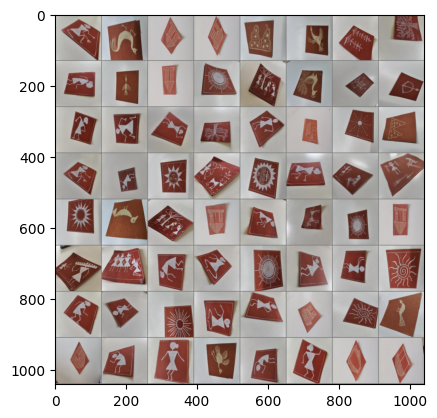

In [5]:
# Print Images to verify
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
images, labels = next(iter(dataloader))

# Show images
imshow(torchvision.utils.make_grid(images))

## GAN

### Generator

In [6]:
epsilon=0.00005

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input is the latent vector Z.
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # Additional Conv layer
            nn.ConvTranspose2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # State size. (1024x4x4)
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # Additional Conv layer
            nn.ConvTranspose2d(512, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # State size. (512x8x8)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # State size. (256x16x16)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # State size. (128x32x32)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64, eps=epsilon),
            nn.ReLU(True),
            nn.Dropout(0.4),

            # State size. (64x64x64)
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Tanh activation to output images with pixel values in range [-1, 1]
            # Final state size. (3x128x128)
        )

    def forward(self, x):
        x = x.view(-1, 100, 1, 1)  # Reshape input noise vector into a batch of inputs for ConvTranspose2d
        output = self.model(x)
        return output

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            # Input size. (3x128x128)
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (64x64x64)
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (128x32x32)
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (256x16x16)
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (512x8x8)
            nn.Conv2d(512, 1024, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (1024x4x4)
            nn.Conv2d(1024, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output a single scalar per image indicating real or fake
        )

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1)  # Flatten to [batch_size, 1]

### Initialize the Models

In [8]:
gen = Generator().to(device)
dis = Discriminator().to(device)

## Train

In [9]:
def train(n_epochs, dataloader, optimizer_dis, optimizer_gen, dis, gen):
  for epoch in range(n_epochs):
        # Initialize losses
        d_loss = 0.0
        g_loss = 0.0
        num_batch = 0

        for i, (real_image, _) in enumerate(dataloader):
          real_image = real_image.to(device)
          batch_size = real_image.size(0)

          # Train Discriminator
          optimizer_dis.zero_grad()

          # Real Data
          real_pred = dis(real_image)
          real_label = torch.ones_like(real_pred, device=device, dtype=torch.float32)
          real_loss =  F.binary_cross_entropy(real_pred, real_label, reduction='mean')

          # Fake Data
          noise = torch.randn(batch_size, 100, 1, 1, device=device)
          gen_out = gen(noise)
          fake_pred = dis(gen_out)
          fake_label = torch.zeros_like(fake_pred, device=device, dtype=torch.float32)
          fake_loss =  F.binary_cross_entropy(fake_pred, fake_label, reduction='mean')

          dis_loss = (real_loss+fake_loss)/2
          dis_loss.backward()
          optimizer_dis.step()

          # Train Generator
          optimizer_gen.zero_grad()

          noise = torch.randn(batch_size, 100, 1, 1, device=device)
          gen_out = gen(noise)
          dis_out = dis(gen_out)
          # label = real_label = torch.ones_like(dis_out, device=device, dtype=torch.float32)
          gen_loss =  F.binary_cross_entropy(dis_out, real_label, reduction='mean')

          gen_loss.backward()
          optimizer_gen.step()

          # Accumulate losses
          d_loss += dis_loss.item()
          g_loss += gen_loss.item()
          num_batch += 1


        # Print losses
        # if i % 1 == 0:
        avg_d_loss = d_loss/num_batch
        avg_g_loss = g_loss/num_batch
        print(f"Epoch [{epoch + 1}] Loss D: {avg_d_loss:.4f} Loss G: {avg_g_loss:.4f}")

In [10]:
n_epochs = 10  # Number of epochs for training
# lr = 0.0001  # Learning rate
optimizer_dis = optim.Adam(dis.parameters(), lr=0.00004, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0004, betas=(0.5, 0.999))

In [11]:
train(n_epochs, dataloader, optimizer_dis, optimizer_gen, dis, gen)

Epoch [1] Loss D: 0.2907 Loss G: 4.3732
Epoch [2] Loss D: 0.3650 Loss G: 4.2598
Epoch [3] Loss D: 0.3294 Loss G: 4.0559
Epoch [4] Loss D: 0.2630 Loss G: 3.7329
Epoch [5] Loss D: 0.3346 Loss G: 4.1838
Epoch [6] Loss D: 0.2821 Loss G: 4.0090
Epoch [7] Loss D: 0.3075 Loss G: 3.8622
Epoch [8] Loss D: 0.3512 Loss G: 3.3635
Epoch [9] Loss D: 0.2585 Loss G: 3.1418
Epoch [10] Loss D: 0.3050 Loss G: 3.5314


## Try out the Generator

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


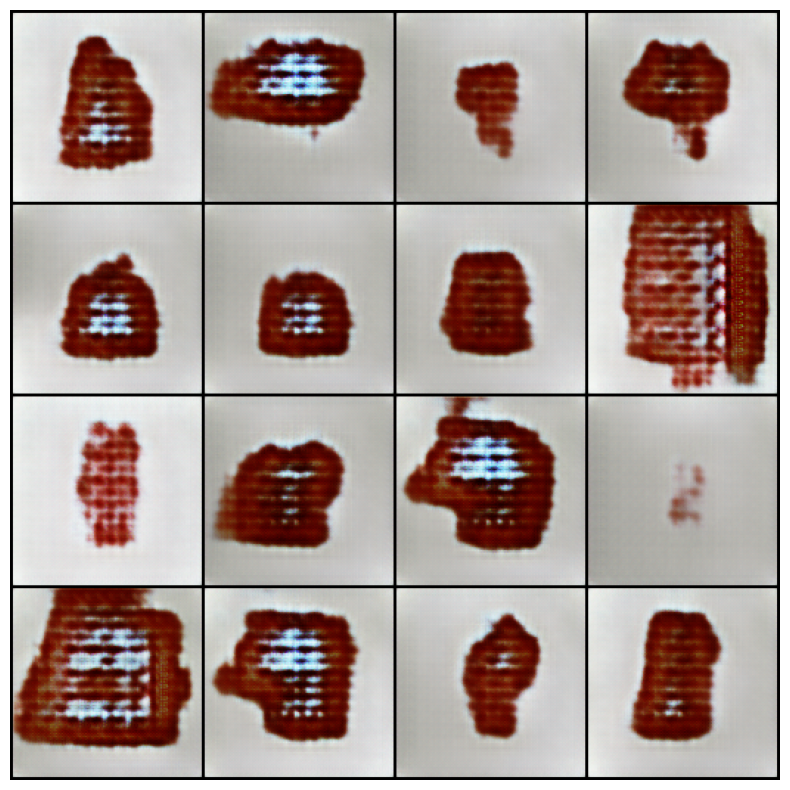

In [12]:
from torchvision.utils import make_grid

# Set the model to evaluation mode
gen.eval()

num_images = 16  # Number of images to generate
latent_dim = 100  # Dimension of the latent vector
noise = torch.randn(num_images, latent_dim, 1, 1)  # Generate random noise

# Generate images from the noise
# Ensure that noise is on the same device as the model
noise = noise.to(next(gen.parameters()).device)  # Move noise to the device of the model
fake_images = gen(noise)

# Convert images to a suitable format for displaying
fake_images = (fake_images + 1) / 2  # Adjust from [-1, 1] to [0, 1]
grid = make_grid(fake_images, nrow=4)  # Create a grid of images

# Plot the images
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().detach().numpy())  # Convert to numpy and plot
plt.axis('off')
plt.show()